In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import torch,cv2
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

from univdt.components import NIH

import copy
def min_max_norm(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image
def post_process_cam(prob, actmap: np.ndarray, image: np.ndarray, threshold: 0.5, color_contour=(255,0,255)) -> np.ndarray:
    if prob < threshold:
        draw = copy.deepcopy(image)
        mask = np.zeros_like(image)
        return draw, mask
    actmap = min_max_norm(actmap)
    new_cam = copy.deepcopy(actmap)

    # for calc contours
    new_cam2 = np.where(new_cam > threshold, 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(new_cam2, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    new_cam = np.where(new_cam > threshold, new_cam, 0)

    filtered_contours = []
    for contour in contours:
        # 컨투어 내부의 최대 값 찾기
        max_value = np.max(new_cam * (cv2.drawContours(np.zeros_like(new_cam),
                                                       [contour], 0, 1,
                                                       thickness=cv2.FILLED)))
        # 최대 값이 0.8 이상인 경우만 남기기
        if max_value >= 0.8:
            filtered_contours.append(contour)
    # 원본에 컨투어 그리기
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    draw = cv2.drawContours(copy.deepcopy(image),
                            filtered_contours, -1, color_contour, 1)
    mask = cv2.drawContours(np.zeros_like(image),
                            filtered_contours, -1, 1, -1)
    mask = cv2.cvtColor(actmap, cv2.COLOR_GRAY2RGB) * mask
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    return draw, mask

In [3]:
root_dir = '/data1/dongseopkim/datasets/nih/' # TODO: set root dir
nih = partial(NIH, root_dir=root_dir, transform=None)

# nih_train = nih(split='train')
# print(len(nih_train))
# assert len(nih_train) == 76599

nih_val = nih(split='val')
print(len(nih_val))
assert len(nih_val) == 9925

# nih_test = nih(split='test')
# print(len(nih_test))
# assert len(nih_test) == 25596

# nih_trainval = nih(split='trainval')
# print(len(nih_trainval))
# assert len(nih_trainval) == 76599+9925

9925


(1024, 1024, 1) [13]
(1024, 1024, 1) [ 9 14]
(1024, 1024, 1) [0]


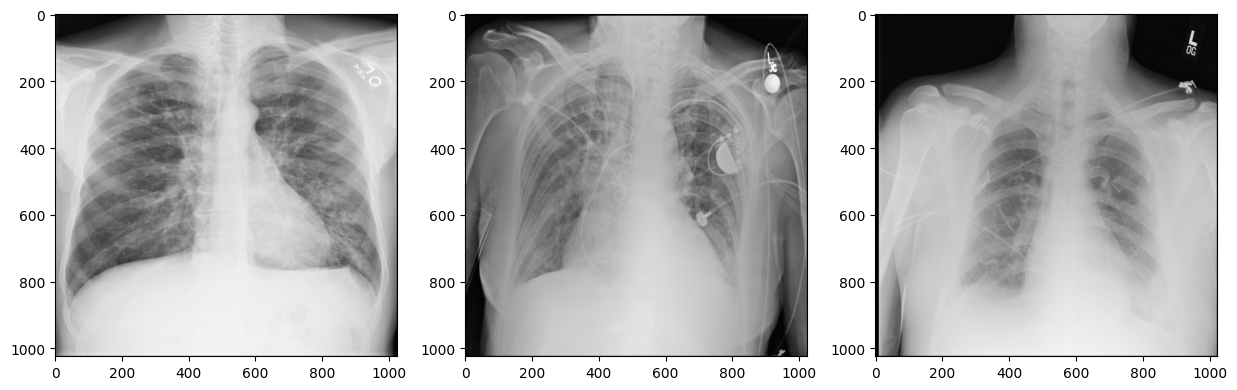

In [3]:
data= nih_val.load_data(0)
image = data['image']
label = data['label']
print(image.shape, label) # 0 : normal, 1: TB, 2: Latent TB
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')

data= nih_val.load_data(20)
image = data['image']
label = data['label']
print(image.shape, label) # 0 : normal, 1: TB, 2: Latent TB
plt.subplot(1,3,2)
plt.imshow(image, cmap='gray')

data= nih_val.load_data(50)
image = data['image']
label = data['label']
print(image.shape, label) # 0 : normal, 1: TB, 2: Latent TB
plt.subplot(1,3,3)
plt.imshow(image, cmap='gray')

In [4]:
# !pip install torchxrayvision
# !pip install grad-cam

In [22]:
import torchxrayvision as xrv

data= nih_val.load_data(125)
image = data['image']
label = data['label']
print(image.shape, label) 

image = cv2.resize(image, (512,512))
image = np.expand_dims(image, axis=2)
print(image.shape, label)

image = xrv.datasets.normalize(image, 255) 
image:np.ndarray = image.mean(2)[None, ...] # Make single color channel
image = image.astype(dtype=np.float32)
print(image.shape, label)
image = torch.from_numpy(image)
print(image.shape, label, image.dtype)

model = xrv.models.ResNet(weights="resnet50-res512-all")
outputs = model(image[None,...]) # or model.features(img[None,...]) 

from pprint import pprint 
pprint(dict(zip(model.pathologies,outputs[0].detach().numpy())))

(1024, 1024, 1) [0]
(512, 512, 1) [0]
(1, 512, 512) [0]
torch.Size([1, 512, 512]) [0] torch.float32
{'Atelectasis': 0.052989762,
 'Cardiomegaly': 0.006757745,
 'Consolidation': 0.006313077,
 'Edema': 0.00033717463,
 'Effusion': 0.028003117,
 'Emphysema': 0.0009935425,
 'Enlarged Cardiomediastinum': 0.5,
 'Fibrosis': 0.005304438,
 'Fracture': 0.0067796325,
 'Hernia': 0.0009738111,
 'Infiltration': 0.07600906,
 'Lung Lesion': 0.5,
 'Lung Opacity': 0.00017274328,
 'Mass': 0.006020151,
 'Nodule': 0.01650333,
 'Pleural_Thickening': 0.0067362315,
 'Pneumonia': 0.0014652248,
 'Pneumothorax': 0.0031723168}


In [5]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [6]:
cam = GradCAM(model=model, target_layers=model.model.layer4)

In [7]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

Cardiomegaly


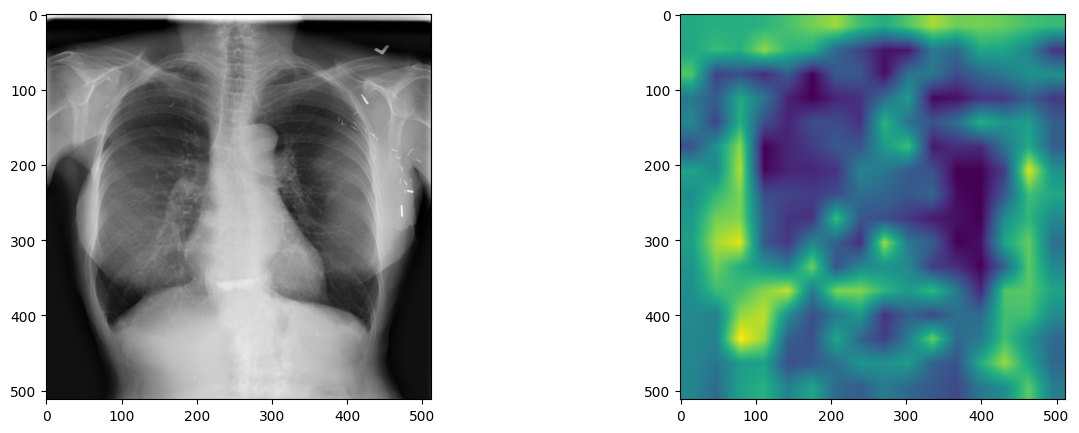

In [14]:
idx = 10
print(model.pathologies[idx])
actmap = cam(input_tensor=image[None,...], targets=[ClassifierOutputTarget(idx)])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(image[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(actmap[0])

In [15]:
tt = min_max_norm(image[0].numpy())*255.0
# print(tt.min(), tt.max())
tt = cv2.cvtColor(tt.astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw, mask = post_process_cam(0.5, actmap[0], tt, 0.5)

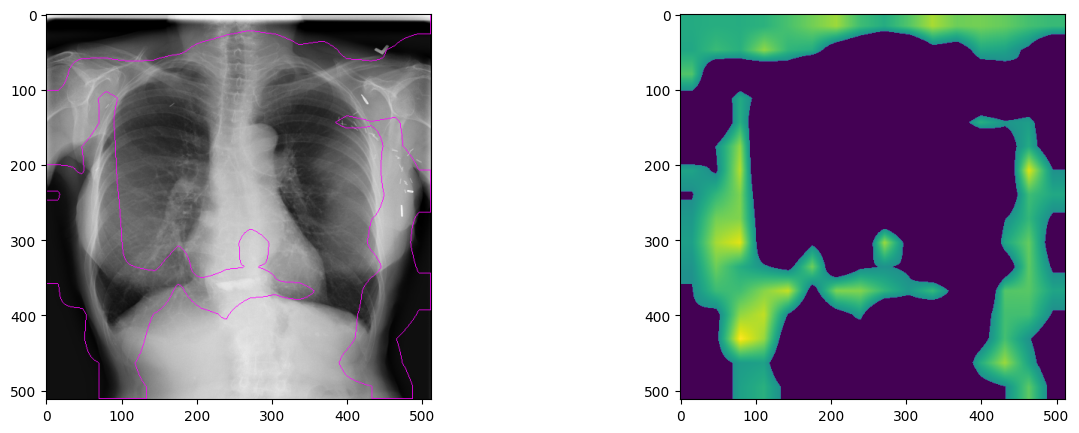

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(draw)
plt.subplot(1,2,2)
plt.imshow(mask)

In [39]:
image[0].numpy().shape

(512, 512)

In [23]:
image.numpy().shape # C H W

(1, 512, 512)

In [14]:
data = nih_val.load_data(50)

In [15]:
data.keys()

dict_keys(['image', 'label', 'path', 'age', 'gender', 'view_position', 'pid', 'fup'])

In [20]:
data['view_position']

'ap'

In [13]:
data['fup']

0

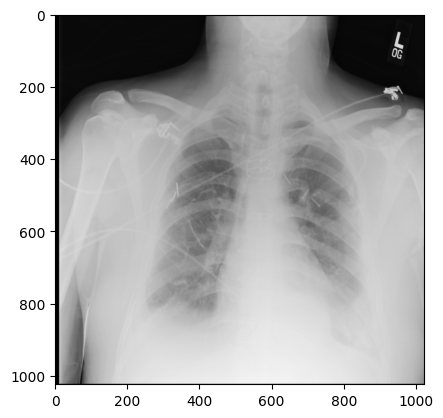

In [21]:
plt.imshow(data['image'], cmap='gray')